<a href="https://colab.research.google.com/github/Olivia-Feldman/NUGAN-DISTGAN/blob/Olivia/NuGAN%2BDISTGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up the environment

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy as np
import time
import matplotlib.pyplot as plt
from math import floor

# Download the MNIST dataset

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=False)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Showing shape of train and test dataset

In [3]:
print("Train Shape:", train_dataset.data.shape, "Test Shape:", test_dataset.data.shape)

Train Shape: torch.Size([60000, 28, 28]) Test Shape: torch.Size([10000, 28, 28])


# CNN for digit classifier

In [4]:
class Net(nn.Module):
    def __init__(self, input_dim=1, output_dim=10, input_size=28, base_size=64):
        super(Net, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size
        self.base_size = base_size
        # self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        # self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # self.conv2 = nn.Conv2d(16, 128, kernel_size=3, stride=1, padding=1)
        # self.conv3 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        # self.fc1 = nn.Linear(128 * 8 * 8, 512)
        # self.fc2 = nn.Linear(512, 128)
        # self.fc3 = nn.Linear(128, 10)

        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim, self.base_size, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(self.base_size, 2*self.base_size, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(2*self.base_size),
            nn.LeakyReLU(0.2),
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * (self.input_size // 4) * (self.input_size // 4), 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, self.output_dim),
            nn.ReLU(),
        )

        #initialize_weights(self)

    def forward(self, x):
        # x = self.pool(F.relu(self.conv1(x)))
        # x = self.pool(F.relu(self.conv2(x)))
        # x = F.relu(self.conv3(x))
        # x = x.view(-1, 128 * 8 * 8)
        # x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        # x = self.fc3(x)
        x = self.conv(x)
        x = x.view(-1, 2*self.base_size * (self.input_size // 4) * (self.input_size // 4))
        x = self.fc(x)
        return x

# Container class for CNN with built-in Train methods

In [5]:
class Classifier():
    def __init__(self, epoch=20, batch_size=500):

        self.epoch_range = epoch
        self.batch_size = batch_size
        valid_ratio = 0.3

        nb_train = int((1.0 - valid_ratio) * len(train_dataset))
        nb_valid =  int(valid_ratio * len(train_dataset))
        train_split_dataset, valid_split_dataset = torch.utils.data.dataset.random_split(train_dataset, [nb_train, nb_valid])

        self.trainloader = torch.utils.data.DataLoader(train_split_dataset, batch_size=self.batch_size,
                                          shuffle=True)
        self.validloader = torch.utils.data.DataLoader(valid_split_dataset, batch_size=self.batch_size,
                                          shuffle=True)
        self.testloader = torch.utils.data.DataLoader(test_dataset, 
                                        batch_size=self.batch_size, 
                                        shuffle=False,
                                        num_workers=1)

        self.net = Net().cuda()

        self.criterion = nn.CrossEntropyLoss().cuda()

        self.optimizer = optim.Adam(self.net.parameters(), lr=0.00146)

        #from google.colab import drive
        #drive.mount('/content/drive')
        self.PATH = 'cifar10_net_test_3.pth'


        # Function to train the CNN classifier
#--------------------------------------------------------------------------------------------------------

    def train(self):

        self.training_loss = []
        self.validation_loss = []

        start_time = time.time()
        best_loss = np.float('inf')
        for epoch in range(self.epoch_range): 

            running_loss = 0.0
            for i, data in enumerate(self.trainloader, 0):
                # get the inputs; data is a list of [inputs, labels]
                # inputs, labels = data[0].to(device), data[1].to(device)
                inputs, labels = data[0].cuda(), data[1].cuda()

                # zero the parameter gradients
                self.optimizer.zero_grad()

                # forward + backward + optimize
                outputs = self.net(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                # print statistics
                running_loss += loss.item()

            epoch_loss = running_loss / (i+1)
            self.training_loss.append(epoch_loss)
            print("Epoch: ", epoch, " train loss: ", '%.3f' % epoch_loss)

            #---------------------------------

            with torch.no_grad(): 
                running_loss = 0.0

                for i, data in enumerate(self.validloader, 0):
                    # get the inputs; data is a list of [inputs, labels]
                    #inputs, labels = data[0].to(device), data[1].to(device)
                    inputs, labels = data[0].cuda(), data[1].cuda()

                    # forward 
                    outputs = self.net(inputs)
                    loss = self.criterion(outputs, labels)

                    # print statistics
                    running_loss += loss.item()


                epoch_loss = running_loss / (i+1)
                self.validation_loss.append(epoch_loss)
                print("Epoch: ", epoch, " validation loss: ", '%.3f' % epoch_loss)

                # save the best model based on validation loss
                if epoch_loss < best_loss:
                    #torch.save(self.net.state_dict(), self.PATH)
                    best_loss = epoch_loss

        time_elap = (time.time() - start_time) // 60
        print('Finished Training in %d mins' % time_elap)

        plt.plot(range(self.epoch_range), self.training_loss, 'k-')
        plt.title('train loss vs. epoch')
        plt.xlabel('epoch')
        plt.ylabel('train_loss')
        plt.show()

        plt.plot(range(self.epoch_range), self.validation_loss, 'k-')
        plt.title('validation loss vs. epoch')
        plt.xlabel('epoch')
        plt.ylabel('validation_loss')
        plt.show()


    def test_accuracy(self):

        correct = 0
        total = 0

        with torch.no_grad():
            for data in self.testloader:
                images, labels = data
                outputs = self.net(images.cuda())
                #print("Outputs shape:", outputs.shape)
                _, predicted = torch.max(outputs.data, 1)
                #print("predicted:", predicted.shape)
                total += labels.size(0)
                correct += (predicted == labels.cuda()).sum().item()

        print('Accuracy of the network on the 10000 test images: %.3F %%' % (
            100 * correct / total))


# Training the digit classifier

Epoch:  0  train loss:  0.215
Epoch:  0  validation loss:  0.084
Epoch:  1  train loss:  0.059
Epoch:  1  validation loss:  0.068
Epoch:  2  train loss:  0.038
Epoch:  2  validation loss:  0.054
Epoch:  3  train loss:  0.026
Epoch:  3  validation loss:  0.055
Epoch:  4  train loss:  0.018
Epoch:  4  validation loss:  0.057
Epoch:  5  train loss:  0.014
Epoch:  5  validation loss:  0.049
Epoch:  6  train loss:  0.008
Epoch:  6  validation loss:  0.047
Epoch:  7  train loss:  0.006
Epoch:  7  validation loss:  0.051
Epoch:  8  train loss:  0.007
Epoch:  8  validation loss:  0.054
Epoch:  9  train loss:  0.007
Epoch:  9  validation loss:  0.053
Epoch:  10  train loss:  0.008
Epoch:  10  validation loss:  0.061
Epoch:  11  train loss:  0.009
Epoch:  11  validation loss:  0.055
Epoch:  12  train loss:  0.007
Epoch:  12  validation loss:  0.051
Epoch:  13  train loss:  0.003
Epoch:  13  validation loss:  0.047
Epoch:  14  train loss:  0.002
Epoch:  14  validation loss:  0.048
Epoch:  15  tra

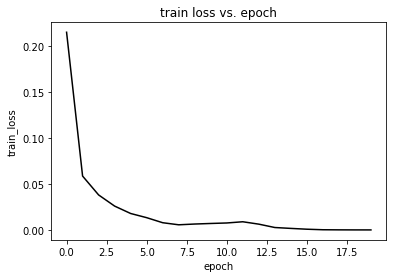

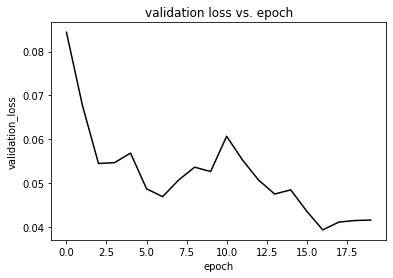

In [6]:
classifier = Classifier()
classifier.train()

# Method for testing accuracy of the digit classifier

In [7]:
classifier.test_accuracy()

Accuracy of the network on the 10000 test images: 99.040 %


# Method for visualizing output of the discriminator

* Produces a single row of 10 images

In [8]:
def visualize_results(gan):
      sample_z_ = torch.rand((10, gan.z_dim)).cuda()
      samples = gan.G(sample_z_)
      samples = samples.cpu().data.numpy().transpose(0, 2, 3, 1)
      samples = (samples + 1) / 2
      plt.figure(figsize=((1,10)))
      fig,ax = plt.subplots(1,10)
      for i in range(10):
          s=ax[i].imshow(np.squeeze(samples[i,]))
          s=ax[i].get_xaxis().set_visible(False)
          s=ax[i].get_yaxis().set_visible(False)
      s=plt.show()

# Define a function to initialize the weights of the network

In [9]:
def initialize_weights(net):
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.ConvTranspose2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()

In [10]:
class autoencoder(nn.Module):
    def __init__(self, output_dim, base_size=64):
        super(autoencoder, self).__init__()
        self.output_dim = output_dim
        self.base_size = base_size
        c = self.base_size

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=self.base_size, kernel_size=4, stride=2, padding=1) # out: c x 14 x 14
        self.conv2 = nn.Conv2d(in_channels=self.base_size, out_channels=self.base_size*2, kernel_size=4, stride=2, padding=1) # out: c x 7 x 7
        self.fc = nn.Linear(in_features=self.base_size*2*7*7, out_features=self.output_dim)
        self.bn1 = nn.BatchNorm2d(self.base_size)
        self.bn2 = nn.BatchNorm2d(self.base_size*2)
        initialize_weights(self)   
            
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.bn1(x)
        x = F.relu(self.conv2(x))
        x = self.bn2(x)
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        x = self.fc(x)
        return x

In [11]:
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim, input_size=28, base_size=64):
        super(Generator, self).__init__()  
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = 28
        self.base_size = base_size

        self.fc = nn.Sequential(
            nn.Linear(self.input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 2*self.base_size * (self.input_size // 4) * (self.input_size // 4)),
            nn.BatchNorm1d(2*self.base_size * (self.input_size // 4) * (self.input_size // 4)),
            nn.ReLU(),
        )

        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(2*self.base_size, self.base_size, 4, 2, 1),
            nn.BatchNorm2d(self.base_size),
            nn.ReLU(),
            nn.ConvTranspose2d(self.base_size, self.output_dim, 4, 2, 1),
            nn.Tanh(),
        )

        initialize_weights(self)           
    
    # forward method
    def forward(self, x): 
       # x = x.view(-1, self.input_size * self.input_size)
        x = self.fc(x)
        x = x.view(-1, 2*self.base_size, (self.input_size // 4), (self.input_size // 4))
        x = self.deconv(x)
        return x




class Discriminator(nn.Module):
  def __init__(self, input_dim, output_dim, input_size=28, base_size=64):
        super(Discriminator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size
        self.base_size = base_size



 
        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim, self.base_size, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(self.base_size, 2*self.base_size, 4, 2, 1),
            nn.BatchNorm2d(2*self.base_size),
            nn.LeakyReLU(0.2),
        )
        self.fc = nn.Sequential(
            nn.Linear(2*self.base_size * (self.input_size // 4) * (self.input_size // 4), 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, self.output_dim),
            
        )
        self.Sig = nn.Sigmoid()

        initialize_weights(self)

     # forward method
  def forward(self, x):
        x = self.conv(x)
        y = x.view(-1, 2*self.base_size * (self.input_size // 4) * (self.input_size // 4))
        logits  = self.fc(y) # logits 
        prob = self.Sig(logits) ## prob

        return prob,logits,x

# Method for calculating sigmoid logot loss of discriminator

In [12]:

# Sigmoid loss with logits, keep as tensor 
# z = labels , torch.ones_like discriminator sigmoid prob
# x =  discriminator logits prob 

def Sigmoid_logits_loss(logits, labels):
  z = labels
  x = logits 
  loss = 0
  for i, x in enumerate(x):
    for j, z in enumerate(z):
      if x >0:
        loss = x - x * z + torch.log(1 + torch.exp(-x))
      else:
        loss = - x * z + torch.log(1 + torch.exp(x))
      loss += loss
    return loss


# Calculate the Eigenvalues for Discriminator/Generator

In [13]:
from scipy.sparse import linalg

def get_eigenvectors(model, loss, dataloader):
    # Adds up the number of weights in the model
    num_params = sum(p.numel() for p in model.parameters())

    hv = HessianVector(model=model, 
                       dataloader=dataloader, 
                       loss=loss)
    
    A = linalg.LinearOperator((num_params,num_params), matvec=lambda v: hv.calculate(torch.tensor(v).float()))

    #print("\tGot eigenvectors", A.shape)
    # Gets 'k' with the Largest (algebraic) eigenvalues
    k = 5
    vals, vecs = linalg.eigsh(A, k=k, mode='LA')

    no_grad_indices = []

    for index, val in enumerate(vals):
        if (val > 500):
            no_grad_indices.append(np.argmax(vecs[:, index]))
        print("\t", val, np.argmax(vecs[:, index]))


    w_count = 0
    if (len(no_grad_indices) > 0):
        for i, p in enumerate(model.parameters()):
            prev_w = w_count
            w_count = w_count + p.numel()
            for index in no_grad_indices:
                if (w_count >= index) and (index > prev_w): # and (p.grad is not None):
                    p.grad.data.zero_()
                    print("Zeroing gradients")

    print("updated hessian")

    # print(vecs[0], vecs[1])
    # print(vals.shape, vecs.shape)
    # print(np.argmax(vecs[:, 0]))

    #print("\tEigenvalues are {:.2f} and {:.2f}".format(vals[0],vals[1]))

# Hessian Vector Class

* scipy.sparse.linalg.LinearOperator

In [14]:
class HessianVector():

    def __init__(self, model, dataloader, loss, percentage=0.2):
        self.size = int(sum(param.numel() for param in model.parameters()))
        self.grad_vec = torch.zeros(self.size)
        self.percentage = percentage
        self.dataloader = dataloader
        self.model = model
        self.loss = loss


    def calculate(self, vector):
        full_hessian = None
        # Place vector on the GPU
        vector = vector.cuda()

        grad_vec = None

        batch_grad = self.prepare_grad()

        #print("Batch Shape:", batch_grad.shape)

        self.zero_grad()
        # Take the second gradient
        grad_grad = torch.autograd.grad(batch_grad, self.model.parameters(), grad_outputs=vector, only_inputs=True, retain_graph=True, allow_unused=True)
        # Concatentate the results over the different components of the network
        hessian_vec_prod = torch.cat([g.contiguous().view(-1) for g in grad_grad])
        # Adds/Sets Full Hessian
        if full_hessian is not None:
            full_hessian += hessian_vec_prod
        else:
            full_hessian = hessian_vec_prod

        # Hessian must be returned on the CPU
        return full_hessian.cpu()

    def zero_grad(self):
        """
        Zeros out the gradient info for each parameters and vectorize
        """

        for p in self.model.parameters():
            if p.grad is not None:
                p.grad.data.zero_()


    def prepare_grad(self):


        grad_vec = None

        grad_dict = torch.autograd.grad(self.loss, self.model.parameters(), create_graph=True, retain_graph=True, allow_unused=True)
        grad_vec = torch.cat([g.contiguous().view(-1) for g in grad_dict])
        self.grad_vec = grad_vec
        return self.grad_vec

# Method for determinign inception score of GAN

In [15]:
def inception_score(gan, n_split=10, eps=1E-16):

      num_images = 100
      sample_z_ = torch.rand((num_images, gan.z_dim)).cuda()
      #print(sample_z_.shape)
      samples = gan.G(sample_z_)
      #print(samples.shape)

      samples_np = samples.cpu().data.numpy()

      # enumerate splits of images/predictions
      scores = list()
      n_part = floor(num_images / n_split)

      for i in range(n_part):
          # retrieve subset of images
          ix_start, ix_end = i * n_part, (i+1) * n_part
          subset = samples_np[ix_start:ix_end]
          # convert from uint8 to float32
          subset = subset.astype('float32')
          # predict p(y|x)
          outputs = classifier.net(torch.from_numpy(subset).cuda())
          outputs = F.softmax(outputs,dim=1)

          p_yx = outputs.cpu().data.numpy()
          p_yx = np.expand_dims(p_yx, 0)

          # calculate p(y)
          p_y = np.expand_dims(p_yx.mean(axis=1), 0)

          # calculate KL divergence using log probabilities
          kl_d = p_yx * (np.log(p_yx + eps) - np.log(p_y + eps))

          # sum over classes
          sum_kl_d = kl_d.sum(axis=1)

          # average over images
          avg_kl_d = np.mean(sum_kl_d)

          # undo the log
          is_score = np.exp(avg_kl_d)

		      # store scores
          scores.append(is_score)
        
      # average across images
      is_avg, is_std = np.mean(scores), np.std(scores)
      return is_avg,is_std
     
      #print(is_avg, is_std)

# Creating GAN Network

In [16]:
from torch.autograd import grad as torch_grad

class GAN():
    def __init__(self,params):
        # parameters
        self.epoch = params['max_epochs']
        self.sample_num = 100
        self.batch_size = 300
        self.input_size = 28
        self.z_dim = params['z_dim']
        self.base_size = params['base_size']

     
        self.lamda_p = 1.0     # regularization term of gradient penalty
        self.lamda_r = 1.0    # autoencoders regularization term  
       
        
        
        # load dataset
        self.data_loader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=self.batch_size, 
                                               shuffle=True)
        data = self.data_loader.__iter__().__next__()[0]

        print(data.shape[1])

        # initialization of the generator and discriminator and autoencoder 
        self.A = autoencoder(output_dim=self.z_dim, base_size=self.base_size).cuda()
        self.G = Generator(input_dim=self.z_dim, output_dim=data.shape[1], input_size=self.input_size,base_size=self.base_size).cuda()
        self.D = Discriminator(input_dim=data.shape[1], output_dim=1, input_size=self.input_size,base_size=self.base_size).cuda()
      

        self.A_optimizer =  optim.Adam(self.A.parameters(), lr=params['lr_g'], betas=(params['beta1'], params['beta2']),eps=1e-09)
        self.G_optimizer = optim.Adam(self.G.parameters(), lr=params['lr_g'], betas=(params['beta1'], params['beta2']),eps=1e-09)
        self.D_optimizer = optim.Adam(self.D.parameters(), lr=params['lr_d'], betas=(params['beta1'], params['beta2']),eps=1e-09)
        
      
    
        
# Fucntion to train the GAN, where you alternate between the training of the genenator and discriminator
#--------------------------------------------------------------------------------------------------------

    def train(self):
        self.train_hist = {}
        self.train_hist['D_loss'] = []
        self.train_hist['G_loss'] = []
        self.train_hist['IS_score'] = []

        # Setting up the labels for real and fake images
        self.y_real_, self.y_fake_ = torch.ones(self.batch_size,1).fill_(0.9).type(torch.float32).cuda(), torch.zeros(self.batch_size, 1).cuda()
        
        print('training start!!')

        for epoch in range(self.epoch):
            epoch_start_time = time.time()


            for iter, (x_, _) in enumerate(self.data_loader):
                if iter == self.data_loader.dataset.__len__() // self.batch_size:
                    break
                z_ = torch.rand((self.batch_size, self.z_dim))
               
                x_, z_ = x_.cuda() ,z_.cuda()
        
                #-------------Train Autoencoder & Generator to minimize reconstruction loss ------------# 
                # auto-encoders and its regularizatize 
                # zero the gradients 

                self.D_optimizer.zero_grad() 
                self.A_optimizer.zero_grad()
                # reconstructed image
                recon = self.A(x_)

                self.G_optimizer.zero_grad()
                X_r = self.G(recon) # reconstructed iamges from generator 
               # print("\tX_r:", X_r.shape)
                X_f = self.G(z_) # fake images from generator 
                #print("\tX_f:", X_f.shape)
                X_r, X_f = X_r, X_f
                
                D_real_prob, D_real_logits, D_real = self.D(x_)
                D_recon_prob, D_recon_logits,D_recon= self.D(X_r)
                D_fake_prob, D_fake_logits,D_fake = self.D(X_f)

                #print(D_real.shape)
                #print(x_.shape)

                ##auto-encoders and Regularization from Dist-Gan paper 

                R_loss = torch.mean(torch.square(D_real-D_recon))
                #print("\tR_loss:", R_loss.shape)
                f = torch.mean(D_recon - D_fake) #distance between reconstructed imgs and reconstructed fake imgs 
                #print("\tf:", f.shape)
                # w parmeter = sqrt(latent dim * 1/ feature dim ) = .1562 for 100
                # latent dim 1 wp = .01562
                # latent dim 10 wp = .04939

                wp = np.sqrt(self.z_dim/4096)
                g = torch.mean(recon - z_) * wp # distance between reconstruced imgs and noise # higher value = initial lowvD training loss  
                #print("\tg:", g.shape)
                R_reg = torch.square(f - g)

               
                # Train Autoencoder with R_loss 
                R_loss = R_loss + self.lamda_r * R_reg
                #print("\tR_loss", R_loss.shape)
                R_loss.backward()
                self.A_optimizer.step()
                
                D_real_prob, D_real_logits, d_real = self.D(x_.detach())
                D_recon_prob, D_recon_logits,D_recon= self.D(X_r.detach())
                D_fake_prob, D_fake_logits,D_fake = self.D(X_f.detach())


                #Train Generator with G_Loss 
               
                G_loss = torch.abs(torch.mean(D_real_prob) - torch.mean(D_fake_prob))

                if (((iter + 1) % 50) == 0):
                #     print("Generator Eigen Values")
                #     get_eigenvectors(self.G, G_loss, self.data_loader)
                    print(G_loss)

                G_loss.backward()
                self.G_optimizer.step()



               #-----------Train Discriminator --------#######
                
                #Train Discriminator with Discriminator Score 
                D_real_prob, D_real_logits, d_real = self.D(x_.detach())
                D_recon_prob, D_recon_logits,D_recon= self.D(X_r.detach())
                D_fake_prob, D_fake_logits,D_fake = self.D(X_f.detach())
                


                # interpolation     
                epsilon = torch.rand(x_.size())
                epsilon = epsilon.cuda()
                interpolation = x_ * epsilon + (1-epsilon) * X_f
                d_inter_prob, d_inter_logits, d_inter = self.D(interpolation)

                # Gradient Penalty 
                gradients = torch_grad(d_inter_logits, interpolation, grad_outputs=torch.ones(d_inter_logits.size()).cuda())[0]
              
                slopes = torch.sqrt(torch.mean(torch.square(gradients),1))
                gp = torch.mean((slopes-1)**2)
            
                #print(D_real_logits.shape)
            
                # Discriminator loss on data
                d_loss_real = torch.mean(Sigmoid_logits_loss( D_real_logits,torch.ones_like(D_real_prob)))
                d_loss_recon = torch.mean(Sigmoid_logits_loss(D_recon_logits, torch.ones_like(D_recon_prob)))
                d_loss_fake = torch.mean(Sigmoid_logits_loss(D_fake_logits,torch.zeros_like(D_fake_prob)))
               # print(d_loss_real.shape)

                # loss w.r.t gradient penalty and reconstruction term 
                D_loss = d_loss_real + d_loss_recon + d_loss_fake
                D_loss = D_loss + self.lamda_p * gp

                if (((iter + 1) % 50) == 0):
                    print(D_loss)
                    print("Discriminator Eigen Values")
                    indices = get_eigenvectors(self.D, D_loss, self.data_loader)
              
                #train Discriminator
                
                D_loss.backward()
                self.D_optimizer.step()



                # 5. Set the current loss in self.train_hist['D_loss]
                self.train_hist['D_loss'].append(D_loss.item())
                
      
     
                #---------------Train Generator to minimize discriminator score --------#
                D_real_prob, D_real_logits, d_real = self.D(x_.detach())
                D_recon_prob, D_recon_logits,D_recon= self.D(X_r.detach())
                D_fake_prob, D_fake_logits,D_fake = self.D(X_f.detach())
             
                #self.G_optimizer.zero_grad()
                G_loss = torch.abs(torch.mean(D_real_prob) - torch.mean(D_fake_prob))

                if (((iter + 1) % 50) == 0):
                #     print("Generator Eigen Values")
                #     get_eigenvectors(self.G, G_loss, self.data_loader)
                    print(G_loss)

                G_loss.backward()
                self.G_optimizer.step()
                # 5. Set the current loss in self.train_hist['G_loss]    
                self.train_hist['G_loss'].append(G_loss.item())

                # Print iterations and losses

                if ((iter + 1) % 50) == 0:
              
                  print("Epoch: [%2d] [%4d/%4d] D_loss: %.8f, G_loss: %.8f" %
                          ((epoch + 1), (iter + 1), self.data_loader.dataset.__len__() // self.batch_size, D_loss.item(), G_loss.item()))
          
                     # Visualize results
            if ((epoch + 1) % 10) == 0:
                with torch.no_grad():
                  print("Training at Epoch:")
                  print(epoch)
                  visualise_output(self)
                  is_avg, _ = inception_score(self)
                  self.train_hist['IS_score'].append(is_avg)
           
            with torch.no_grad():
                is_avg, _ = inception_score(self)
                self.train_hist['IS_score'].append(is_avg)
           

              
           
            


        print("Training finished!")

# Visualize output of Generator by creating 10x10 grid


In [17]:
import matplotlib.pyplot as plt
plt.ion()
import torchvision.utils

def visualise_output(gan):

    with torch.no_grad():
        sample_z_ = torch.rand((gan.base_size, gan.z_dim)).cuda()
        samples = gan.G(sample_z_)
        samples = samples.cpu()
        samples = (samples + 1) / 2
        np_imagegrid = torchvision.utils.make_grid(samples[1:100], 10, 5).detach().numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()


# Training the GAN model

In [18]:
params = {'beta1': 0.5, 'beta2': 0.9,'lr_g':0.002,'lr_d':0.002,'max_epochs':1}

params['z_dim'] = 1
params['base_size'] = 64

gan = GAN(params)
gan.train()

1
training start!!
tensor(0.0161, device='cuda:0', grad_fn=<AbsBackward>)
tensor(5.1427, device='cuda:0', grad_fn=<AddBackward0>)
Discriminator Eigen Values
	 -73.46495 6558856
	 52.46864 6558642
	 57.537086 6558730
	 126.33054 6558893
	 278.1392 6558857
updated hessian
tensor(0.0301, device='cuda:0', grad_fn=<AbsBackward>)
Epoch: [ 1] [  50/ 200] D_loss: 5.14272833, G_loss: 0.03013003
tensor(0.0029, device='cuda:0', grad_fn=<AbsBackward>)
tensor(9.4636, device='cuda:0', grad_fn=<AddBackward0>)
Discriminator Eigen Values
	 -43.70175 6558527
	 -36.703716 6558678
	 37.631252 6558833
	 123.08968 6558730
	 140.71077 895
updated hessian
tensor(0.0029, device='cuda:0', grad_fn=<AbsBackward>)
Epoch: [ 1] [ 100/ 200] D_loss: 9.46357822, G_loss: 0.00292540
tensor(0.0088, device='cuda:0', grad_fn=<AbsBackward>)
tensor(3.8771, device='cuda:0', grad_fn=<AddBackward0>)
Discriminator Eigen Values
	 -33.08594 895
	 -10.040848 6559153
	 33.25605 895
	 72.64217 6559168
	 190.98694 6558380
updated hessi

# Loss History for GAN optimization

* The loss will achieve a low value when it can reliably separate the two classes.
* The loss will achieve a low value when it can successfully fool the discriminator

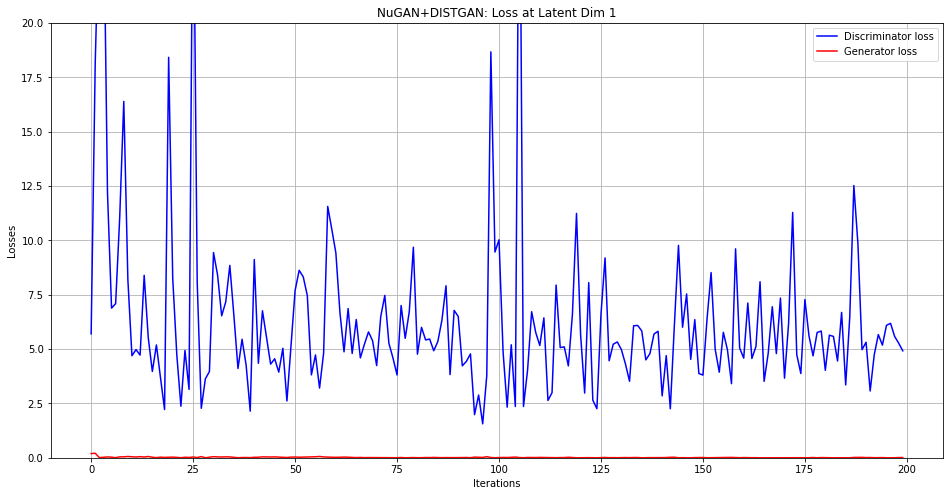

In [19]:
plt.figure(figsize=(16,8))
s=plt.plot(gan.train_hist['D_loss'],c='b')
s=plt.plot(gan.train_hist['G_loss'],c='r')
s = plt.ylim((0,20))
s = plt.grid()
s=plt.legend(('Discriminator loss','Generator loss'))
s=plt.title("NuGAN+DISTGAN: Loss at Latent Dim " + str(gan.z_dim))
s=plt.ylabel("Losses")
s=plt.xlabel("Iterations")

# Plotting inception Score for model with latent dim


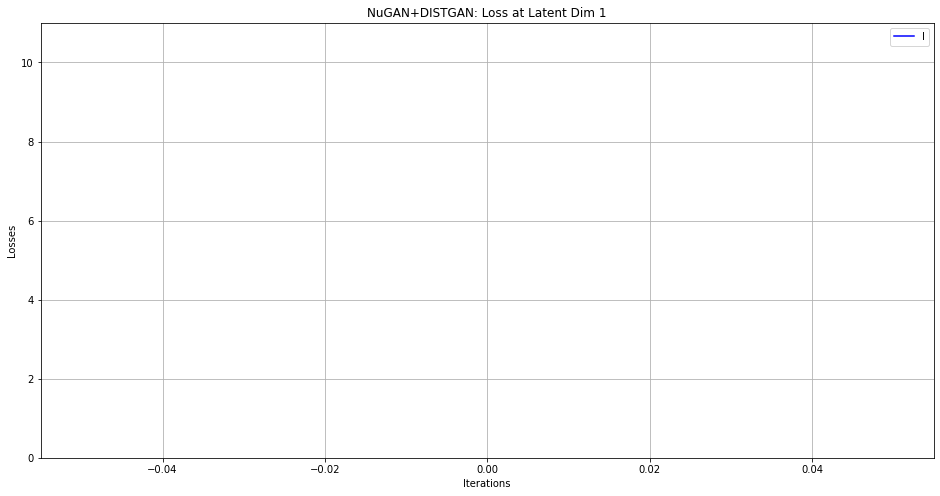

In [20]:
plt.figure(figsize=(16,8))
s=plt.plot(gan.train_hist['IS_score'],c='b')
s = plt.ylim((0,11))
s = plt.grid()
s=plt.legend('Inception Score')
s=plt.title("NuGAN+DISTGAN: Loss at Latent Dim " + str(gan.z_dim))
s=plt.ylabel("Losses")
s=plt.xlabel("Iterations")

# model with latent dim 10

1
training start!!
tensor(0.0247, device='cuda:0', grad_fn=<AbsBackward>)
tensor(5.3329, device='cuda:0', grad_fn=<AddBackward0>)
Discriminator Eigen Values
	 -41.52117 6558162
	 43.752 6558697
	 75.26867 6559168
	 103.31856 225
	 161.13924 6558238
updated hessian
tensor(0.0172, device='cuda:0', grad_fn=<AbsBackward>)
Epoch: [ 1] [  50/ 200] D_loss: 5.33287096, G_loss: 0.01716375
tensor(0.0063, device='cuda:0', grad_fn=<AbsBackward>)
tensor(5.5146, device='cuda:0', grad_fn=<AddBackward0>)
Discriminator Eigen Values
	 -36.5712 6558926
	 30.734528 6558298
	 37.447205 6558926
	 42.122562 6558926
	 417.91507 6559002
updated hessian
tensor(0.0136, device='cuda:0', grad_fn=<AbsBackward>)
Epoch: [ 1] [ 100/ 200] D_loss: 5.51464844, G_loss: 0.01358998
tensor(0.0003, device='cuda:0', grad_fn=<AbsBackward>)
tensor(5.6789, device='cuda:0', grad_fn=<AddBackward0>)
Discriminator Eigen Values
	 -40.576546 6558328
	 14.705683 6558751
	 31.73054 6558298
	 104.96862 6559008
	 164.96136 6558710
updated 

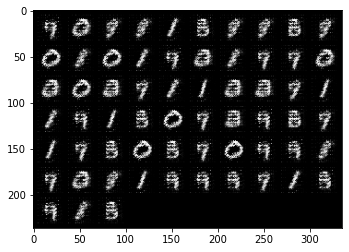

tensor(0.1744, device='cuda:0', grad_fn=<AbsBackward>)
tensor(2.6426, device='cuda:0', grad_fn=<AddBackward0>)
Discriminator Eigen Values
	 -5.0080986 6558762
	 4.3947225 927
	 7.158145 6558153
	 14.969368 6558329
	 21.910677 6559168
updated hessian
tensor(0.1724, device='cuda:0', grad_fn=<AbsBackward>)
Epoch: [11] [  50/ 200] D_loss: 2.64260387, G_loss: 0.17240280
tensor(0.1960, device='cuda:0', grad_fn=<AbsBackward>)
tensor(5.4322, device='cuda:0', grad_fn=<AddBackward0>)
Discriminator Eigen Values
	 -18.808636 6558309
	 -11.301123 6558319
	 13.94013 6558699
	 38.8993 895
	 66.150475 488
updated hessian
tensor(0.1994, device='cuda:0', grad_fn=<AbsBackward>)
Epoch: [11] [ 100/ 200] D_loss: 5.43215895, G_loss: 0.19937566
tensor(0.1564, device='cuda:0', grad_fn=<AbsBackward>)
tensor(8.0605, device='cuda:0', grad_fn=<AddBackward0>)
Discriminator Eigen Values
	 -12.740938 6558699
	 12.7467 6558370
	 14.557545 6558153
	 28.622684 6559094
	 317.2945 6558200
updated hessian
tensor(0.1661, de

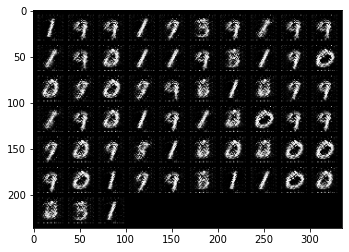

tensor(0.6049, device='cuda:0', grad_fn=<AbsBackward>)
tensor(1.4879, device='cuda:0', grad_fn=<AddBackward0>)
Discriminator Eigen Values
	 3.2462707 6558802
	 3.8774981 507
	 5.226817 804
	 10.088588 883
	 49.595905 895
updated hessian
tensor(0.6144, device='cuda:0', grad_fn=<AbsBackward>)
Epoch: [21] [  50/ 200] D_loss: 1.48793173, G_loss: 0.61443198
tensor(0.4209, device='cuda:0', grad_fn=<AbsBackward>)
tensor(4.7604, device='cuda:0', grad_fn=<AddBackward0>)
Discriminator Eigen Values
	 -16.099876 804
	 -9.738182 6559077
	 11.484201 6559168
	 18.772512 6558632
	 28.170084 340
updated hessian
tensor(0.4424, device='cuda:0', grad_fn=<AbsBackward>)
Epoch: [21] [ 100/ 200] D_loss: 4.76041937, G_loss: 0.44244236
tensor(0.5832, device='cuda:0', grad_fn=<AbsBackward>)
tensor(2.4787, device='cuda:0', grad_fn=<AddBackward0>)
Discriminator Eigen Values
	 -10.306803 886
	 8.852431 645
	 10.087748 708
	 18.24488 750
	 50.066574 6558924
updated hessian
tensor(0.5872, device='cuda:0', grad_fn=<Ab

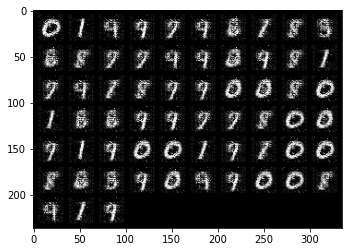

tensor(0.6549, device='cuda:0', grad_fn=<AbsBackward>)
tensor(1.2862, device='cuda:0', grad_fn=<AddBackward0>)
Discriminator Eigen Values
	 1.4916812 542
	 1.6879737 528
	 3.2760017 1057
	 5.636712 6559168
	 16.403713 344
updated hessian
tensor(0.6485, device='cuda:0', grad_fn=<AbsBackward>)
Epoch: [31] [  50/ 200] D_loss: 1.28623545, G_loss: 0.64848077
tensor(0.7027, device='cuda:0', grad_fn=<AbsBackward>)
tensor(5.2463, device='cuda:0', grad_fn=<AddBackward0>)
Discriminator Eigen Values
	 -31.486612 6558699
	 -14.212026 537
	 15.8946495 6559084
	 59.958584 117
	 96.4457 116
updated hessian
tensor(0.6842, device='cuda:0', grad_fn=<AbsBackward>)
Epoch: [31] [ 100/ 200] D_loss: 5.24632215, G_loss: 0.68423629
tensor(0.7133, device='cuda:0', grad_fn=<AbsBackward>)
tensor(1.2520, device='cuda:0', grad_fn=<AddBackward0>)
Discriminator Eigen Values
	 -1.658926 6558802
	 1.3619338 369
	 1.5664451 6558802
	 8.864978 1059
	 30.306225 564
updated hessian
tensor(0.7098, device='cuda:0', grad_fn=<

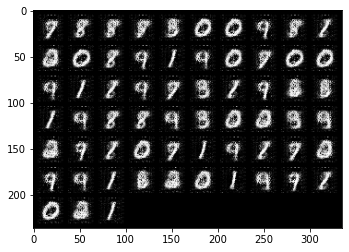

tensor(0.7166, device='cuda:0', grad_fn=<AbsBackward>)
tensor(1.4838, device='cuda:0', grad_fn=<AddBackward0>)
Discriminator Eigen Values
	 2.2719262 116
	 2.706891 342
	 5.126566 895
	 11.661766 302
	 31.699203 113
updated hessian
tensor(0.7075, device='cuda:0', grad_fn=<AbsBackward>)
Epoch: [41] [  50/ 200] D_loss: 1.48382580, G_loss: 0.70747524
tensor(0.6643, device='cuda:0', grad_fn=<AbsBackward>)
tensor(1.5703, device='cuda:0', grad_fn=<AddBackward0>)
Discriminator Eigen Values
	 -6.094855 529
	 4.118951 612
	 4.4125123 882
	 11.841935 723
	 102.896774 807
updated hessian
tensor(0.6596, device='cuda:0', grad_fn=<AbsBackward>)
Epoch: [41] [ 100/ 200] D_loss: 1.57032359, G_loss: 0.65955222
tensor(0.1993, device='cuda:0', grad_fn=<AbsBackward>)
tensor(4.5530, device='cuda:0', grad_fn=<AddBackward0>)
Discriminator Eigen Values
	 -22.786783 6558802
	 -9.677546 132357
	 11.099517 6556918
	 12.535517 117
	 62.125305 516
updated hessian
tensor(0.2510, device='cuda:0', grad_fn=<AbsBackward

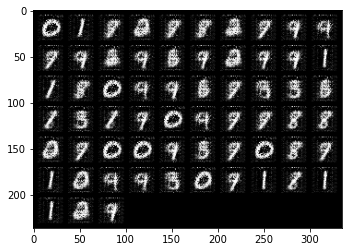

tensor(0.7538, device='cuda:0', grad_fn=<AbsBackward>)
tensor(3.9637, device='cuda:0', grad_fn=<AddBackward0>)
Discriminator Eigen Values
	 -56.672737 1030
	 -18.133146 372
	 -14.886153 93
	 13.717638 379
	 83.26196 108
updated hessian
tensor(0.7431, device='cuda:0', grad_fn=<AbsBackward>)
Epoch: [51] [  50/ 200] D_loss: 3.96370411, G_loss: 0.74313974
tensor(0.7305, device='cuda:0', grad_fn=<AbsBackward>)
tensor(1.3393, device='cuda:0', grad_fn=<AddBackward0>)
Discriminator Eigen Values
	 -0.6875173 1029
	 0.43574 480
	 0.92545176 107
	 1.556177 174
	 3.7267978 84
updated hessian
tensor(0.7252, device='cuda:0', grad_fn=<AbsBackward>)
Epoch: [51] [ 100/ 200] D_loss: 1.33927894, G_loss: 0.72521555
tensor(0.8120, device='cuda:0', grad_fn=<AbsBackward>)
tensor(2.1213, device='cuda:0', grad_fn=<AddBackward0>)
Discriminator Eigen Values
	 -15.72319 6558699
	 9.180397 880
	 14.680248 80
	 43.629436 99
	 140.98119 535
updated hessian
tensor(0.8429, device='cuda:0', grad_fn=<AbsBackward>)
Epoch

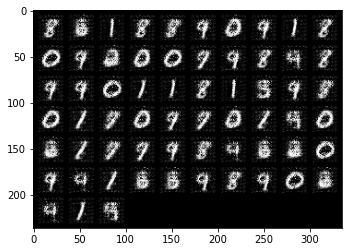

tensor(0.8135, device='cuda:0', grad_fn=<AbsBackward>)
tensor(1.4596, device='cuda:0', grad_fn=<AddBackward0>)
Discriminator Eigen Values
	 -4.8713703 6559033
	 -2.5694504 6557080
	 3.77053 724
	 10.545891 539
	 54.074154 724
updated hessian
tensor(0.7976, device='cuda:0', grad_fn=<AbsBackward>)
Epoch: [61] [  50/ 200] D_loss: 1.45955777, G_loss: 0.79757369
tensor(0.7275, device='cuda:0', grad_fn=<AbsBackward>)
tensor(1.2938, device='cuda:0', grad_fn=<AddBackward0>)
Discriminator Eigen Values
	 1.0404615 126
	 1.3634417 92
	 3.0763063 97
	 12.866522 80
	 21.488827 728
updated hessian
tensor(0.7459, device='cuda:0', grad_fn=<AbsBackward>)
Epoch: [61] [ 100/ 200] D_loss: 1.29376495, G_loss: 0.74585736
tensor(0.8081, device='cuda:0', grad_fn=<AbsBackward>)
tensor(1.2116, device='cuda:0', grad_fn=<AddBackward0>)
Discriminator Eigen Values
	 0.34815836 80
	 0.78309125 166
	 1.0264782 539
	 1.6704664 6559168
	 7.590154 589
updated hessian
tensor(0.8061, device='cuda:0', grad_fn=<AbsBackward>

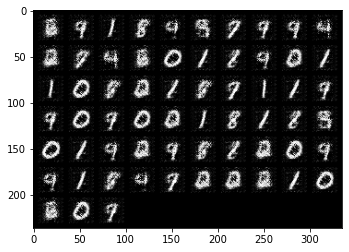

tensor(0.8293, device='cuda:0', grad_fn=<AbsBackward>)
tensor(2.2662, device='cuda:0', grad_fn=<AddBackward0>)
Discriminator Eigen Values
	 -41.060825 6558699
	 -12.062294 107
	 5.625143 728
	 15.775988 537
	 229.3558 6556651
updated hessian
tensor(0.8370, device='cuda:0', grad_fn=<AbsBackward>)
Epoch: [71] [  50/ 200] D_loss: 2.26619005, G_loss: 0.83700132
tensor(0.8564, device='cuda:0', grad_fn=<AbsBackward>)
tensor(1.4385, device='cuda:0', grad_fn=<AddBackward0>)
Discriminator Eigen Values
	 -0.8403138 537
	 1.8839709 1058
	 2.6201262 1072
	 11.861675 6556718
	 16.847145 532
updated hessian
tensor(0.8577, device='cuda:0', grad_fn=<AbsBackward>)
Epoch: [71] [ 100/ 200] D_loss: 1.43852913, G_loss: 0.85765624
tensor(0.7134, device='cuda:0', grad_fn=<AbsBackward>)
tensor(2.0333, device='cuda:0', grad_fn=<AddBackward0>)
Discriminator Eigen Values
	 -1.724324 118
	 2.2777593 808
	 5.8181524 271
	 12.297206 461
	 24.363499 451
updated hessian
tensor(0.7155, device='cuda:0', grad_fn=<AbsBac

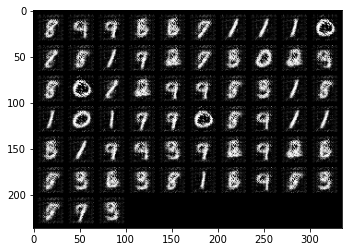

tensor(0.8271, device='cuda:0', grad_fn=<AbsBackward>)
tensor(1.1928, device='cuda:0', grad_fn=<AddBackward0>)
Discriminator Eigen Values
	 0.1756543 1060
	 0.24979469 209
	 0.6312917 263
	 1.3480661 6557535
	 3.2541254 6559069
updated hessian
tensor(0.8210, device='cuda:0', grad_fn=<AbsBackward>)
Epoch: [81] [  50/ 200] D_loss: 1.19280553, G_loss: 0.82101059
tensor(0.7321, device='cuda:0', grad_fn=<AbsBackward>)
tensor(2.1663, device='cuda:0', grad_fn=<AddBackward0>)
Discriminator Eigen Values
	 -5.8767266 216
	 -3.2182584 211
	 -3.0331569 44
	 8.991051 539
	 127.12343 32
updated hessian
tensor(0.7275, device='cuda:0', grad_fn=<AbsBackward>)
Epoch: [81] [ 100/ 200] D_loss: 2.16626000, G_loss: 0.72745347
tensor(0.7035, device='cuda:0', grad_fn=<AbsBackward>)
tensor(2.6388, device='cuda:0', grad_fn=<AddBackward0>)
Discriminator Eigen Values
	 -7.1295347 107
	 7.0708203 730
	 20.172316 6558426
	 33.99604 6558699
	 55.500748 113
updated hessian
tensor(0.7358, device='cuda:0', grad_fn=<Abs

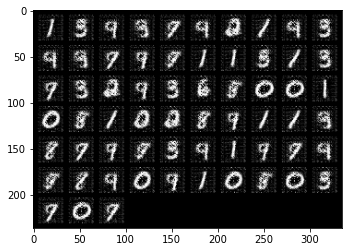

tensor(0.5755, device='cuda:0', grad_fn=<AbsBackward>)
tensor(11.9789, device='cuda:0', grad_fn=<AddBackward0>)
Discriminator Eigen Values
	 -15.127911 578
	 -10.536401 132369
	 15.384066 733
	 18.775711 582
	 90.767815 1069
updated hessian
tensor(0.6214, device='cuda:0', grad_fn=<AbsBackward>)
Epoch: [91] [  50/ 200] D_loss: 11.97890949, G_loss: 0.62140739
tensor(0.7196, device='cuda:0', grad_fn=<AbsBackward>)
tensor(1.7144, device='cuda:0', grad_fn=<AddBackward0>)
Discriminator Eigen Values
	 -2.1471732 6558559
	 2.0192895 6558802
	 4.1111736 733
	 6.245247 532
	 40.531002 581
updated hessian
tensor(0.7257, device='cuda:0', grad_fn=<AbsBackward>)
Epoch: [91] [ 100/ 200] D_loss: 1.71442461, G_loss: 0.72567976
tensor(0.7807, device='cuda:0', grad_fn=<AbsBackward>)
tensor(1.2486, device='cuda:0', grad_fn=<AddBackward0>)
Discriminator Eigen Values
	 -0.47181556 6558559
	 0.5323026 6559084
	 0.8935751 733
	 1.1471788 1069
	 9.434179 542
updated hessian
tensor(0.7868, device='cuda:0', grad

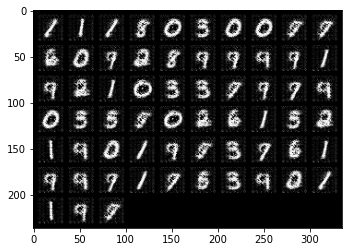

tensor(0.7331, device='cuda:0', grad_fn=<AbsBackward>)
tensor(1.2657, device='cuda:0', grad_fn=<AddBackward0>)
Discriminator Eigen Values
	 1.2518384 528
	 1.4494807 117
	 4.235621 532
	 6.29331 528
	 21.928741 769
updated hessian
tensor(0.7347, device='cuda:0', grad_fn=<AbsBackward>)
Epoch: [101] [  50/ 200] D_loss: 1.26573217, G_loss: 0.73472607
tensor(0.8014, device='cuda:0', grad_fn=<AbsBackward>)
tensor(1.2311, device='cuda:0', grad_fn=<AddBackward0>)
Discriminator Eigen Values
	 1.5469891 346
	 1.8439034 113
	 3.2561872 36
	 11.727083 784
	 49.209232 116
updated hessian
tensor(0.8069, device='cuda:0', grad_fn=<AbsBackward>)
Epoch: [101] [ 100/ 200] D_loss: 1.23107481, G_loss: 0.80693293
tensor(0.6248, device='cuda:0', grad_fn=<AbsBackward>)
tensor(1.3228, device='cuda:0', grad_fn=<AddBackward0>)
Discriminator Eigen Values
	 -0.69199526 6559084
	 0.90243036 6559099
	 0.98589516 152
	 2.0285025 1034
	 14.94871 173
updated hessian
tensor(0.6259, device='cuda:0', grad_fn=<AbsBackward

In [23]:
params = {'beta1': 0.5, 'beta2': 0.9,'lr_g':0.002,'lr_d':0.002,'max_epochs':102}

params['z_dim'] = 10
params['base_size'] = 64

gan2 = GAN(params)


gan2.train()

In [ ]:

plt.figure(figsize=(16,8))
s=plt.plot(gan2.train_hist['D_loss'],c='b')
s=plt.plot(gan2.train_hist['G_loss'],c='r')
s = plt.ylim((0,3))
s = plt.grid()
s=plt.legend(('Discriminator loss','Generator loss'))

[4.0132623, 3.8768592, 4.274306, 3.7858233, 4.4437895, 4.6416426, 4.1757455, 4.8671923, 5.0785904, 4.9352155, 4.3642898, 5.094779, 5.019348, 4.8777285, 5.3937902, 5.1650724, 5.2548647, 4.613161, 4.946233, 4.905707, 5.2078547, 5.686788, 4.842948, 4.346604, 4.292438, 4.3068695, 4.998839, 4.3268595, 4.893142, 4.832125, 4.6640058, 4.908516, 4.8648453, 4.6802497, 5.1115904, 4.602486, 5.2535563, 4.956585, 4.308133, 4.329156, 4.959876, 4.2339315, 4.5851727, 4.719781, 4.4609594, 4.8587785, 4.5630426, 4.3131876, 4.3473144, 4.7644577, 4.5664263, 4.6770263, 4.64701, 5.145481, 4.9947543, 4.889262, 4.7205925, 4.5504045, 5.0024157, 4.627302, 4.661174, 4.93398, 4.4165006, 4.6764126, 4.61551, 4.6862764, 4.801354, 5.154039, 4.757365, 4.1929426, 4.6992607, 5.2711105, 5.2231894, 5.0352216, 4.7430186, 5.1319723, 5.168933, 5.175266, 5.2261844, 4.839828, 5.2082977, 4.6120977, 4.591296, 5.1917944, 5.1058793, 4.759855, 4.421319, 5.0395956, 4.7669845, 5.02291, 4.3719015, 4.836504, 5.0524173, 4.884721, 4.850569

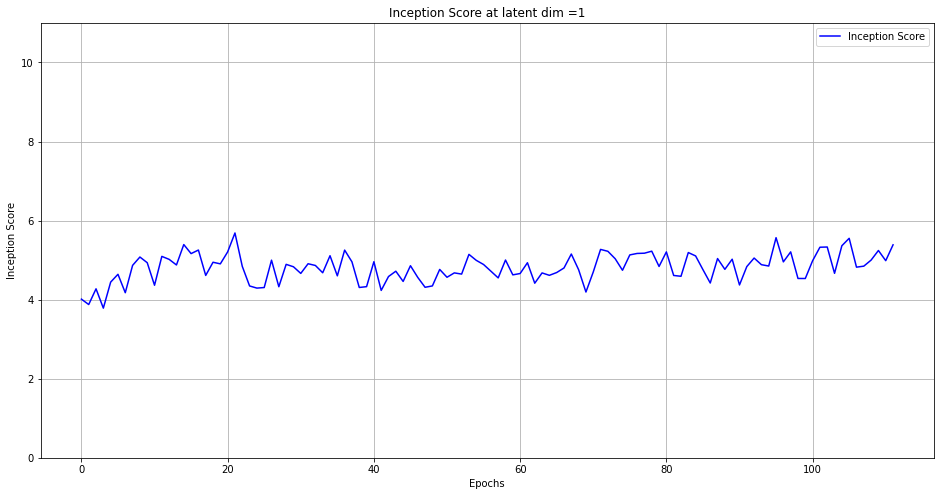

In [37]:
plt.figure(figsize=(16,8))
s=plt.plot(gan2.train_hist['IS_score'],c='b')
s = plt.ylim((0,11))
s = plt.grid()
s=plt.legend(('Inception Score','Generator loss'))
s = plt.xlabel('Epochs')
s = plt.ylabel('Inception Score')
s = plt.title('Inception Score at latent dim =1')
print(gan2.train_hist['IS_score'])

In [38]:
 Dist_1 = [3.603496, 4.768294, 4.5126505, 4.9725404, 4.863921, 4.50452, 4.3576756, 3.855531, 3.8979917, 4.560994, 4.7617846, 4.959994, 4.383441, 4.5076227, 5.159664, 4.481493, 4.866556, 4.302198, 4.4048567, 4.3196616, 4.6716337, 4.435594, 4.1166825, 4.236539, 3.9135692, 4.0301495, 4.259207, 4.3063717, 4.098365, 4.100654, 3.9812825, 4.3219113, 4.088414, 3.7355034, 4.1263943, 4.3421617, 4.226636, 4.660936, 4.8310556, 4.575088, 4.4825764, 4.6916146, 4.7492967, 4.6394463, 4.7564774, 4.9096475, 4.6412625, 4.6632767, 4.835482, 4.8306775, 4.5756087, 4.192922, 4.942333, 4.8025765, 4.7037554, 4.6419024, 4.4923134, 4.64806, 4.208188, 4.851732, 4.40767, 4.3567343, 4.6172957, 4.661907, 4.587736, 5.03289, 4.306573, 4.838383, 4.377837, 4.379924, 4.628848, 4.978087, 4.8307495, 4.8271995, 4.8106084, 5.144473, 4.887771, 5.1482735, 4.6352262, 4.9353204, 4.526723, 4.8113375, 4.2736287, 4.2479634, 4.5218773, 4.587475, 4.570838, 4.452826, 4.4382725, 4.726548, 4.65158, 4.7530174, 4.9224734, 4.803847, 4.8608017, 4.614717, 5.0944223, 4.9066744, 4.5930357, 5.00267]
Dist_NU_1 = [4.0132623, 3.8768592, 4.274306, 3.7858233, 4.4437895, 4.6416426, 4.1757455, 4.8671923, 5.0785904, 4.9352155, 4.3642898, 5.094779, 5.019348, 4.8777285, 5.3937902, 5.1650724, 5.2548647, 4.613161, 4.946233, 4.905707, 5.2078547, 5.686788, 4.842948, 4.346604, 4.292438, 4.3068695, 4.998839, 4.3268595, 4.893142, 4.832125, 4.6640058, 4.908516, 4.8648453, 4.6802497, 5.1115904, 4.602486, 5.2535563, 4.956585, 4.308133, 4.329156, 4.959876, 4.2339315, 4.5851727, 4.719781, 4.4609594, 4.8587785, 4.5630426, 4.3131876, 4.3473144, 4.7644577, 4.5664263, 4.6770263, 4.64701, 5.145481, 4.9947543, 4.889262, 4.7205925, 4.5504045, 5.0024157, 4.627302, 4.661174, 4.93398, 4.4165006, 4.6764126, 4.61551, 4.6862764, 4.801354, 5.154039, 4.757365, 4.1929426, 4.6992607, 5.2711105, 5.2231894, 5.0352216, 4.7430186, 5.1319723, 5.168933, 5.175266, 5.2261844, 4.839828, 5.2082977, 4.6120977, 4.591296, 5.1917944, 5.1058793, 4.759855, 4.421319, 5.0395956, 4.7669845, 5.02291, 4.3719015, 4.836504, 5.0524173, 4.884721, 4.850569, 5.568045, 4.9561324, 5.2083993, 4.535984]
Gan_1 = [4.012427, 2.9447517, 3.0997279, 4.604493, 5.14903, 4.7627826, 5.6185637, 5.001239, 4.9684277, 4.6182623, 5.2529507, 5.793507, 5.654906, 5.2676187, 5.3037114, 4.950691, 5.643359, 5.2556143, 4.919418, 3.8438144, 1.1460803, 1.1298946, 1.2651936, 1.2954252, 1.1989231, 1.1366398, 2.0562909, 1.2382404, 4.137881, 4.120747, 4.3394537, 1.6285871, 1.2867076, 2.5147254, 1.5451937, 1.5960689, 3.9347968, 4.0480714, 4.52044, 3.7173378, 4.6336994, 5.2872615, 5.565242, 5.4365644, 5.493197, 5.408056, 5.6832743, 5.3708572, 5.5557985, 5.593303, 5.389302, 5.7128844, 5.2060146, 5.5644903, 5.3770037, 5.6965685, 5.4871845, 4.7546444, 4.6163855, 1.000351, 1.509556, 2.1056757, 1.0747001, 1.8233154, 1.483712, 1.423825, 2.0738013, 2.0643115, 1.4555016, 3.520768, 3.6186264, 3.7148013, 3.934595, 4.62965, 4.372761, 4.9243436, 4.578868, 5.19168, 5.1466994, 5.7029204, 5.268886, 4.7041063, 4.9092703, 5.770941, 5.8071337, 5.838599, 5.1867104, 5.202615, 5.747017, 5.651261, 6.0703707, 5.4327874, 5.448329, 5.5830526, 5.341165, 5.1753917, 6.310838, 5.6042676, 5.5523906, 4.5849166]

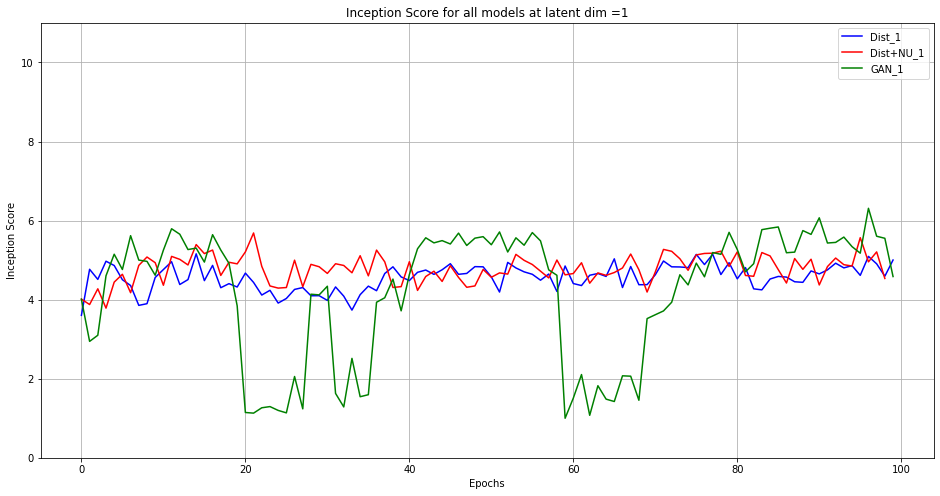

In [62]:
labels = ['Dist_1', 'Dist+NU_1','GAN_1']
plt.figure(figsize=(16,8))
s=plt.plot(Dist_1,c='b')
s=plt.plot(Dist_NU_1,c='r')
s=plt.plot(Gan_1,c='g')
s = plt.ylim((0,11))
s = plt.grid()
s = plt.xlabel('Epochs')
s = plt.ylabel('Inception Score')
s = plt.title('Inception Score for all models at latent dim =1')

s=plt.legend(labels)

In [58]:
 GAN_10 = [6.730912, 6.5597944, 6.1645966, 6.362403, 6.6919227, 5.975125, 6.682448, 6.4183908, 6.1219954, 6.179974, 6.124357, 6.005645, 6.1711397, 6.2479925, 6.516823, 6.2573843, 5.8300695, 6.1555595, 6.0329895, 6.123418, 6.392852, 6.2889204, 5.970919, 5.888665, 6.882622, 5.932897, 6.531678, 6.336293, 6.350805, 5.873515, 6.320784, 5.7714972, 6.124688, 6.1232595, 6.2509623, 5.8273034, 6.108762, 6.5838404, 5.66367, 6.0541368, 6.2551126, 6.4454064, 6.3030143, 6.6418076, 6.792018, 6.221591, 6.4535837, 6.3166165, 6.521848, 6.463342, 6.036295, 5.9290686, 6.280089, 6.503742, 5.8398814, 5.7004824, 6.314563, 5.829536, 6.3400173, 6.1984577, 6.0842714, 6.009201, 6.316997, 6.183158, 6.0359235, 7.0362296, 6.395228, 6.766983, 6.294255, 6.127517, 6.262315, 5.739875, 6.025113, 6.5092416, 6.4561424, 6.5128984, 6.542291, 6.5757523, 6.465693, 6.6437187, 6.3625646, 6.3262615, 6.2089825, 6.6024804, 6.7844086, 6.265948, 6.6917086, 6.4913917, 6.2995195, 6.531504, 5.7833724, 6.098167, 6.9928055, 6.390699, 5.816352, 6.1285524, 6.02735, 6.474964, 5.947741, 6.5126724]

 DIST_GAN_10 = [5.7994432, 5.92352, 5.560693, 5.8004827, 5.9303913, 5.8112288, 5.9705477, 5.5411997, 6.0966096, 6.09587, 5.9193773, 6.0259085, 5.8468113, 6.129353, 5.2852287, 5.3329034, 6.326005, 6.055358, 6.009348, 5.7196164, 6.0931644, 6.4046144, 5.8178864, 6.2482176, 6.012441, 5.7909265, 5.9989343, 5.324517, 6.1115932, 5.824297, 6.214455, 6.0561266, 5.8590765, 5.9202986, 6.273732, 6.1313896, 6.1109776, 5.80292, 5.884351, 5.770063, 5.949813, 5.711483, 5.5427566, 6.070758, 5.7667694, 6.218309, 6.314769, 6.150504, 5.6779656, 5.8564806, 5.842696, 5.8726935, 5.591562, 6.0152903, 5.7260866, 5.957299, 5.7485495, 5.9923143, 5.712823, 5.759424, 6.275271, 5.615595, 5.8768067, 5.56432, 6.565876, 5.847149, 6.102994, 5.92867, 6.464068, 5.86381, 6.4914002, 6.2952156, 5.267693, 5.779079, 5.7918787, 5.4575043, 6.047692, 5.403184, 6.0382185, 5.8103766, 5.503395, 6.014051, 5.671544, 5.5907917, 6.1992292, 5.76756, 5.842126, 5.8992314, 5.837133, 5.6141996, 5.652154, 5.445703, 5.8890414, 6.317977, 5.645129, 5.819735, 6.1736636, 5.795548, 6.3885164, 5.778291, 5.971809, 5.7808514]
 NU_DIST_GAN_10 = [5.816116, 5.623448, 6.123431, 5.5161853, 5.9515495, 6.1601133, 6.236475, 6.176103, 6.2558203, 5.9188905, 5.767597, 6.49018, 5.912725, 6.3439746, 6.100795, 5.5159206, 6.022803, 5.895165, 5.7764406, 5.798173, 5.7662907, 5.74931, 5.912236, 5.8101034, 5.490134, 5.743951, 5.4583573, 5.6566963, 5.7041655, 5.954164, 5.9684896, 5.6785583, 5.4657736, 6.434339, 5.7401266, 5.821977, 5.7543864, 6.2108603, 5.8466425, 5.686632, 5.7162914, 6.033811, 5.83992, 5.7762127, 5.6870375, 5.9487867, 5.5206504, 5.7555385, 5.488874, 5.6864805, 5.963662, 5.8387365, 5.964488, 5.995085, 5.7263594, 5.926098, 6.058999, 5.8144155, 6.0123153, 6.2059355, 5.4492354, 5.124438, 5.4669323, 5.6465664, 6.0389695, 5.7625766, 5.9687185, 6.120119, 5.6221557, 5.841416, 5.5889287, 6.2385726, 6.145978, 5.9486117, 5.840815, 5.862839, 5.671479, 6.0862694, 6.087817, 5.62428, 6.1157465, 5.8376813, 5.802798, 5.960668, 5.9637675, 5.8539567, 5.617631, 5.617003, 5.7563677, 6.103027, 6.0762496, 6.200541, 5.741014, 6.1856575, 6.131281, 6.153669, 6.171562, 5.9447985, 6.105827, 5.656451, 6.1703258, 5.851979, 6.411296, 5.9439573, 5.7717314, 5.9753704, 5.5940013, 5.574191, 5.812387, 5.669744]

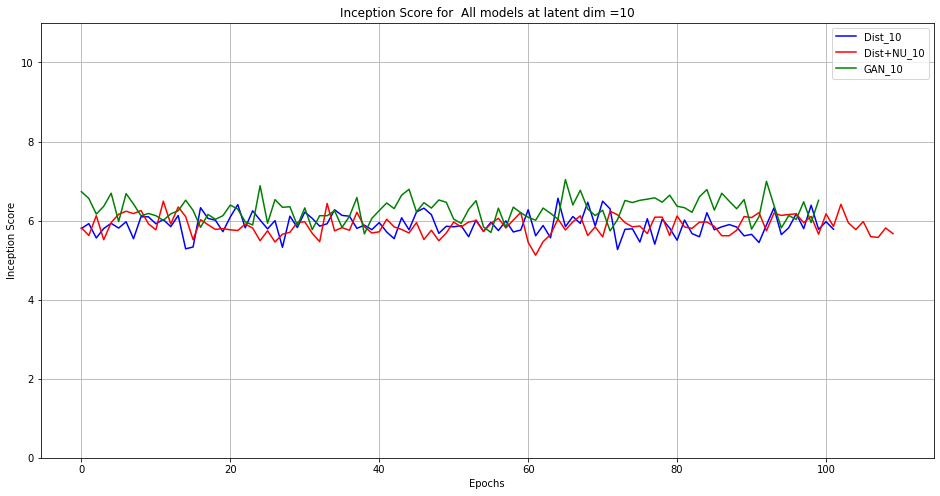

In [64]:
labels = ['Dist_10', 'Dist+NU_10','GAN_10']
plt.figure(figsize=(16,8))
s=plt.plot( DIST_GAN_10 ,c='b')
s=plt.plot( NU_DIST_GAN_10,c='r')
s=plt.plot( GAN_10,c='g')

s = plt.ylim((0,11))
s = plt.grid()
s = plt.xlabel('Epochs')
s = plt.ylabel('Inception Score')
s = plt.title('Inception Score for  All models at latent dim =10')

s=plt.legend(labels)